# Yelp Dataset Business Rating Prediction
The motivation behind this project was to do semantic analysis on a minimum of 20 textual reviews per business. The model would only be exposed to the text data, as well as the overall rating of the business.

The model is constructed using a TF-IDF vectorizer, and fed into an MLP 


### Initial Dataset Cleaning
This stage is for handling the large yelp dataset, as it has an issue being loaded into a pandas dataframe directly from JSON format, we save as tsv file. Then we load tsv file into our pandas dataframe to clean the data, inspecting along the way

In [1]:
# Imports for cleaning operations
import time
import json
import csv
import string
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adadelta,Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Regression chart.
def chart_regression(pred,y,sort=True):
    sns.set_theme()
    plt.figure(figsize=(20,10))
    t = pd.DataFrame({'pred' : pred, 'y' : y})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['pred'].tolist(),label='prediction')
    b = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()

##### SAVING AS TSV FILE DO NOT RUN IF TSV FILE EXISTS

In [ ]:
# Only needed to run once
outfile = open('review_stars.tsv', 'a')
sfile = csv.writer(outfile, delimiter='\t', quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars','text'])

with open('data/yelp_academic_dataset_review.json', encoding='utf-8') as f:
    for line in f:
        row = json.loads(line)
        sfile.writerow([row['business_id'], row['stars'], (row['text'].encode('utf-8'))])
outfile.close()

##### Read as csv, using tabs as delimiter
The data is initially seen here, we only needed our stars, id, and review text columns 

In [2]:
# Load DataFrame
df = pd.read_csv('review_stars.tsv', delimiter='\t', encoding='utf-8')
# Inspect DataFrame
df.head()

,business_id,stars,text
0,-MhfebM0QIsKt87iDN-FNw,2.0,"b'As someone who has worked with many museums,..."
1,lbrU8StCq3yDfr-QMnGrmQ,1.0,b'I am actually horrified this place is still ...
2,HQl28KMwrEKHqhFrrDqVNQ,5.0,"b""I love Deagan's. I do. I really do. The atmo..."
3,5JxlZaqCnk1MnbgRirs40Q,1.0,"b'Dismal, lukewarm, defrosted-tasting ""TexMex""..."
4,IS4cv902ykd8wj1TR0N3-A,4.0,"b'Oh happy day, finally have a Canes near my c..."


##### Merge reviews together
Here we join all the reviews for each business together, turning a corpus of data into a single document. The idea here is that we want to make sure our model interprets the reviews as a whole, instead of considering each individual review. This is because we will predict the businesses' overall rating, as opposed to what each particular review's rating will be.

In [3]:
df_review_agg = df.groupby('business_id')['text'].sum()
df_merged_reviews = pd.DataFrame({'business_id':df_review_agg.index, 
                          'all_reviews':df_review_agg.values})
df_merged_reviews.head()

,business_id,all_reviews
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...
1,--6MefnULPED_I942VcFNA,"b""The bbq pork is very juicy and I only come h..."
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r..."
3,--8LPVSo5i0Oo61X01sV9A,b'Dr. LaCognata is great. He is a great liste...
4,--9QQLMTbFzLJ_oT-ON3Xw,b'Always great customer service. Affordable ha...


##### Load in business dataset
We will use this for merging dataframes to filter out businesses with less than 20 reviews. 

In [5]:
# Load business DataFrame
df_businesses = pd.read_json('data/yelp_academic_dataset_business.json',
                             lines=True)
df_businesses.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [6]:
# Filter business review count and stars
df_businesses = df_businesses[['business_id', 'review_count', 'stars']]

# Merge dataframes
df_merged_reviews = pd.merge(df_merged_reviews, df_businesses, on='business_id')

# Filter all businesses with less than 20 reviews
df_merged_reviews = df_merged_reviews[df_merged_reviews['review_count'] >= 20]

In [7]:
df_merged_reviews.head()

,business_id,all_reviews,review_count,stars
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...,27,4.0
1,--6MefnULPED_I942VcFNA,"b""The bbq pork is very juicy and I only come h...",55,3.0
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",65,4.0
5,--9e1ONYQuAa-CB_Rrw7Tw,"b""On yelp 5 stars = Woohoo! as good as it gets...",1759,4.0
6,--DaPTJW3-tB1vP-PfdTEg,"b""I used to come to this restaurant about two ...",51,4.0


In [8]:
df_ = df_merged_reviews.drop(['review_count'], axis=1)
df_clean.head()

,business_id,all_reviews,stars
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...,4.0
1,--6MefnULPED_I942VcFNA,"b""The bbq pork is very juicy and I only come h...",3.0
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",4.0
5,--9e1ONYQuAa-CB_Rrw7Tw,"b""On yelp 5 stars = Woohoo! as good as it gets...",4.0
6,--DaPTJW3-tB1vP-PfdTEg,"b""I used to come to this restaurant about two ...",4.0


In [ ]:
# Only needed to run once
# DO NOT RUN CELL IF FILE EXISTS
df_clean.to_pickle('data/yelp_reviews_clean.pkl')

## Dataset Setup


### Run the TF-IDF Vectorizer
Here we use chunk processing on the csv file in order to avoid crashing the kernel, and to save memory

**This is a preprocessing step, and is only needed to run once**

In [ ]:
def chunk_generator():
    for chunk in pd.read_csv('data/yelp_reviews_clean.csv', chunksize=100):
        for doc in chunk['all_reviews'].values:
            yield doc

corpus = chunk_generator()
vectorizer = TfidfVectorizer(stop_words='english',min_df=2, max_features=10000, norm='l2')

X = vectorizer.fit_transform(corpus)

# Save as pickle for faster load times
np.save('data/corpus.pkl', arr=X, allow_pickle=True)

### Load Vectorized Matrix
**Needs to be run after every startup**

In [2]:
df = pd.read_csv('data/yelp_reviews_clean.csv')

In [3]:
X = np.load('data/corpus.pkl.npy')

### Split Data Into Training and Testing Sets
Training to testing data ratio of 4:1

In [4]:
X_train_v, X_test_v, y_train, y_test = train_test_split(X, df['stars'], test_size=0.2, random_state=42)

## Model Construction and Training

Separate library used for monitoring.

In [10]:
import wandb
from wandb.keras import WandbCallback

run = wandb.init(project='Project1',
           config={
            "hyper": "parameter"
            })

In [6]:
batch_size = 64
epochs = 100

In [7]:
# Model construction

model = Sequential()

model.add(Dense(1000, input_shape=(10000,)))
model.add(Activation('relu'))

model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              10001000  
_________________________________________________________________
activation (Activation)      (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                25050     
_________________________________________________________________
activation_2 (Activation)    (None, 50)                0

#### wandb
*This is a monitoring software I used called Weights and Biases, an alternative to tensorboard*

This specific set of graphs is the last training cycle I did to try to get the lowest loss possible

In [11]:
%wandb

### Begin Training

In [12]:
# Uncomment to use best weights from my training cycle
#model.load_weights('best_weights.hdf5')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=20, verbose=2, mode='auto')

checkpointer = ModelCheckpoint(filepath="new_weights.hdf5", verbose=1, save_best_only=True)

model.fit(X_train_v, y_train, batch_size=batch_size,
          validation_data=(X_test_v, y_test),
          callbacks=[WandbCallback(), monitor, checkpointer],
          epochs=epochs, verbose=2)

# Re-load best weights to evaluate RMSE and lift chart
model.load_weights('new_weights.hdf5')

# Uncomment to use weights from my best model
#model.load_weights('best_weights.hdf5')

# This is to stop the monitoring tool
run.finish()

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.03128, saving model to best_weights.hdf5
827/827 - 5s - loss: 0.0476 - val_loss: 0.0313
Epoch 2/100

Epoch 00002: val_loss improved from 0.03128 to 0.02834, saving model to best_weights.hdf5
827/827 - 5s - loss: 0.0453 - val_loss: 0.0283
Epoch 3/100

Epoch 00003: val_loss improved from 0.02834 to 0.02771, saving model to best_weights.hdf5
827/827 - 5s - loss: 0.0441 - val_loss: 0.0277
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.02771
827/827 - 4s - loss: 0.0425 - val_loss: 0.0289
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.02771
827/827 - 4s - loss: 0.0421 - val_loss: 0.0305
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.02771
827/827 - 4s - loss: 0.0418 - val_loss: 0.0284
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.02771
827/827 - 4s - loss: 0.0436 - val_loss: 0.0321
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.02771
827/827 - 4s - loss: 0.0428 - val_loss: 0.0306

wandb: ERROR Control-C detected -- Run data was not synced


(test) Score (RMSE): 0.15592157119225086


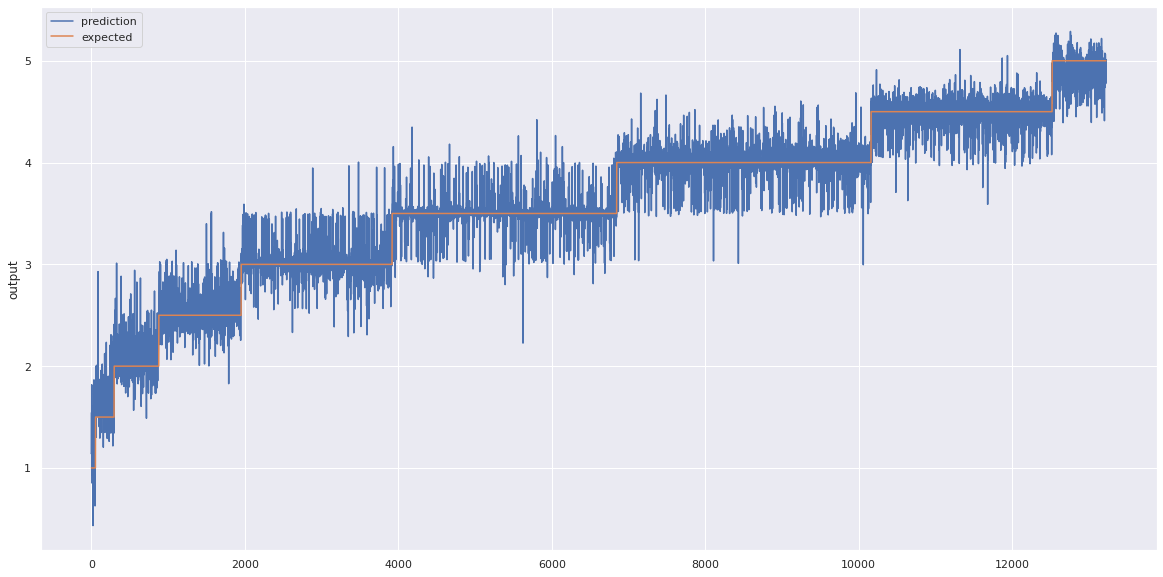

(train) Score (RMSE): 0.08353223113931162


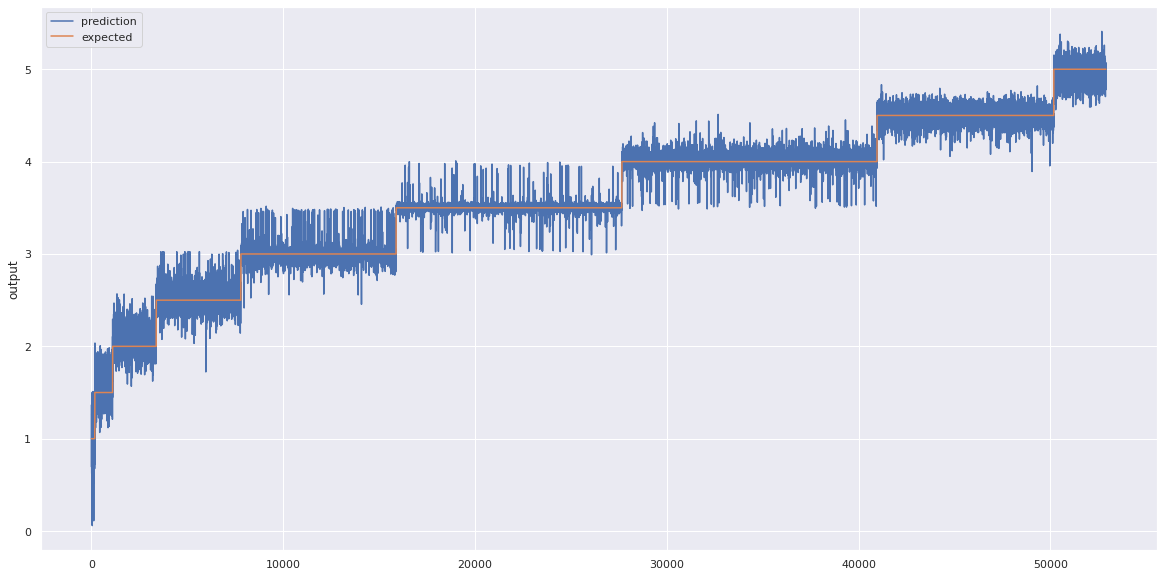

In [66]:
# Load best weights to try to get validation loss as low as possible.
model.load_weights('best_weights.hdf5')

# Make predictions
train_preds = model.predict(X_train_v)
test_preds = model.predict(X_test_v)

# RMSE for testing data + lift chart
score = np.sqrt(metrics.mean_squared_error(test_preds,y_test))
print("(test) Score (RMSE): {}".format(score))
# Plot the chart
chart_regression(test_preds.flatten(),y_test, sort=True)

# RMSE for training data + lift chart
score = np.sqrt(metrics.mean_squared_error(train_preds,y_train))
print("(train) Score (RMSE): {}".format(score))
chart_regression(train_preds.flatten(),y_train, sort=True)

### Confusion Matrix 
I put this here to better represent the predicted values the model represents, as the predictions must be rounded to the nearest rating class.

<AxesSubplot:>

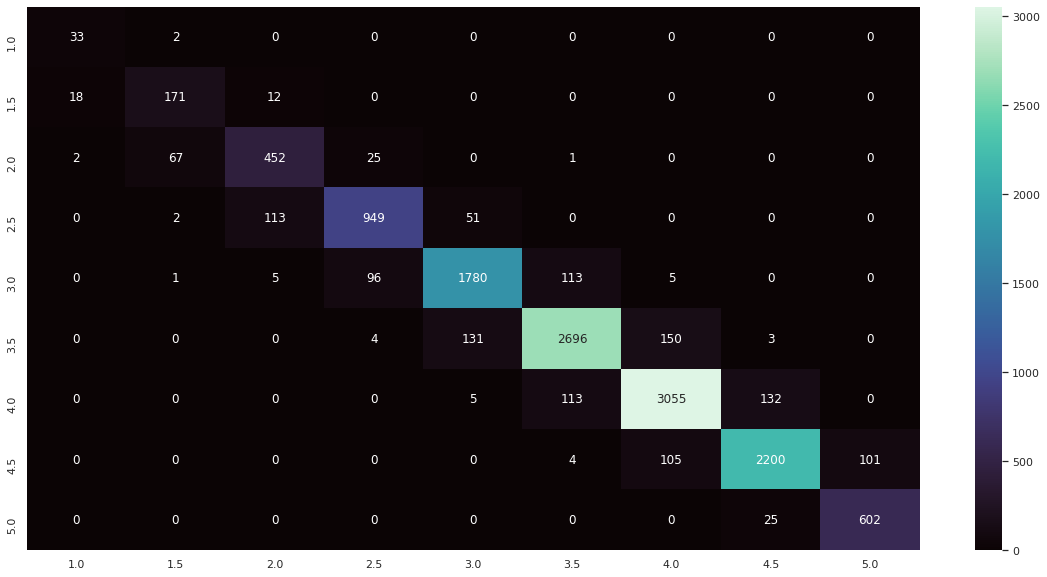

In [77]:
def round_preds(preds):
    def round_single_pred(pred):
        stars = list(np.linspace(1.0, 5.0, 9))
        return min(stars, key=lambda x: abs(x-pred))
                   
    result = np.apply_along_axis(round_single_pred, 1, preds)
    return result
                   
rounded_preds = round_preds(test_preds)


categories = list(np.linspace(1.0, 5.0, 9))
cfm = metrics.confusion_matrix(rounded_preds.astype(str), y_test.astype(str))
plt.figure(figsize=(20,10))
sns.heatmap(cfm,cmap=sns.color_palette("mako", as_cmap=True), annot=True,fmt='',
           xticklabels=categories,yticklabels=categories)

## Examples from Dataset
Here I picked out 5 businesses from the dataset, which included: Taco bell, Burger King, Target, Gamestop, and Red Lobster

In [39]:
businesses = ['Taco Bell, Las Vegas NV', 'Burger King, Charlotte NC', 'Red Lobster, Toronto ON',
              'Target, Glendale AZ', 'Gamestop, Las Vegas NV']

examples = pd.read_pickle('data/examples.pkl')

In [16]:
Y_examples = examples['stars']
X_examples = vectorizer.transform(examples['all_reviews']).todense()

In [19]:
model.load_weights('best_weights.hdf5')

example_preds = model.predict(X_examples)

In [47]:
print("|{:25s}|{:15s}|{:7s}".format("Business", "Predicted", "Actual"))
print("-------------------------------------------------")
for i in range(5):
    print("|{:25s}|{:15s}|{:7s}".format(businesses[i], str(example_preds[i]), str(Y_examples[i])))

|Business                 |Predicted      |Actual 
-------------------------------------------------
|Taco Bell, Las Vegas NV  |[4.022132]     |4.0    
|Burger King, Charlotte NC|[1.144464]     |1.0    
|Red Lobster, Toronto ON  |[4.915038]     |5.0    
|Target, Glendale AZ      |[3.0416842]    |3.0    
|Gamestop, Las Vegas NV   |[4.0290184]    |4.0    
